### Setup Environment:

In [14]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [15]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'educational_level'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [16]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df = df.dropna(subset=['educational_level'])
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


patient  age  sex  dm_time  insulin  insulin_time  oraltreatment_dm  \
0        1   58    1     15.0      1.0           NaN               1.0   
1        1   58    1     15.0      1.0           NaN               1.0   
2        1   58    1     15.0      1.0           NaN               1.0   
3        1   58    1     15.0      1.0           NaN               1.0   
4       10   63    0      7.0      0.0           NaN               1.0   

   systemic_hypertension  insurance  educational_level  ...  nephropathy  \
0                    1.0        0.0                3.0  ...          1.0   
1                    1.0        0.0                3.0  ...          1.0   
2                    1.0        0.0                3.0  ...          1.0   
3                    1.0        0.0                3.0  ...          1.0   
4                    1.0        0.0                2.0  ...          0.0   

   neuropathy  diabetic_foot      file  laterality  final_artifacts  \
0         0.0            0.0   1.1.jpg       right              yes   
1         0.0            0.0   1.2.jpg       right              yes   
2         0.0            0.0   1.3.jpg        left              yes   
3         0.0            0.0   1.4.jpg        left              yes   
4         0.0            0.0  10.1.jpg       right              yes   

   final_quality  final_icdr final_edema normality  
0            yes         4.0          no  abnormal  
1            yes         4.0          no  abnormal  
2            yes         4.0          no  abnormal  
3            yes         4.0          no  abnormal  
4            yes         0.0          no  abnormal  

[5 rows x 25 columns]

In [17]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# for binary: 0: normal, 1-4: abnormal
# Map values to categories
df[LABEL] = df[LABEL].astype(int)
#df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')
#df[LABEL] = df[LABEL].apply(lambda x: '1' if x == 0 else ('2' if x == 1 else ('3' if x == 3 else('4' if x == 4 else('5' if x == 5 else('6' if x == 6 else('7' if x == 7)))))))
mapping = {1: '0', 2: '0', 3: '1', 4: '1', 5: '1', 6: '1', 7: '1'}

df[LABEL] = df[LABEL].apply(lambda x: mapping.get(x, 'default_value'))
print(df[LABEL].value_counts())

0    2859
1    2252
Name: educational_level, dtype: int64


Train data shape: (4088, 25)
Test data shape: (1023, 25)


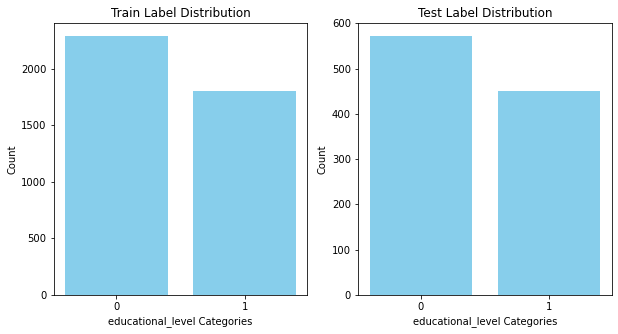

Getting validation set...


In [18]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_val = df_test

### Dataloaders

In [19]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [20]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [21]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


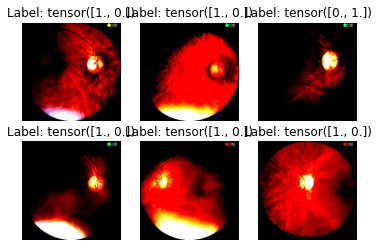

In [22]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [23]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [24]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [2287 1801]


In [25]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 64/64 [00:12<00:00,  5.02it/s]


Epoch 1, Train Loss: 0.08462202380178496, Val Loss: 0.08383270155172795, F1 Score: 0.4926243883483232, acc0.5259042033235581
cm[[138 434]
 [ 51 400]]


100%|██████████| 64/64 [00:12<00:00,  5.01it/s]


Epoch 2, Train Loss: 0.07896182923286688, Val Loss: 0.08706157078268006, F1 Score: 0.5418524839010777, acc0.6285434995112414
cm[[544  28]
 [352  99]]


100%|██████████| 64/64 [00:12<00:00,  4.95it/s]


Epoch 3, Train Loss: 0.06209422006213572, Val Loss: 0.07883167761610821, F1 Score: 0.6607257878997009, acc0.6617790811339198
cm[[367 205]
 [141 310]]


100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


Epoch 4, Train Loss: 0.029293875471921638, Val Loss: 0.0964211612881627, F1 Score: 0.6688394526341598, acc0.6695992179863147
cm[[367 205]
 [133 318]]


100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


Epoch 5, Train Loss: 0.006367025080749045, Val Loss: 0.18136766703537432, F1 Score: 0.6676573342365488, acc0.6901270772238515
cm[[486  86]
 [231 220]]


100%|██████████| 64/64 [00:12<00:00,  4.99it/s]


Epoch 6, Train Loss: 0.0050808896210270404, Val Loss: 0.18088914634427056, F1 Score: 0.6856295126027754, acc0.6881720430107527
cm[[398 174]
 [145 306]]


100%|██████████| 64/64 [00:12<00:00,  4.99it/s]


Epoch 7, Train Loss: 0.002957669247514616, Val Loss: 0.1683576013892889, F1 Score: 0.687036328871893, acc0.6871945259042033
cm[[363 209]
 [111 340]]


100%|██████████| 64/64 [00:12<00:00,  5.00it/s]


Epoch 8, Train Loss: 0.003626929116578026, Val Loss: 0.18760399770690128, F1 Score: 0.6978806413255512, acc0.7028347996089932
cm[[425 147]
 [157 294]]


100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


Epoch 9, Train Loss: 0.0006970740044067725, Val Loss: 0.2120861288276501, F1 Score: 0.7018141086944442, acc0.70772238514174
cm[[434 138]
 [161 290]]


100%|██████████| 64/64 [00:12<00:00,  5.00it/s]


Epoch 10, Train Loss: 8.035005140705209e-05, Val Loss: 0.2247819713957142, F1 Score: 0.6981832298136645, acc0.7028347996089932
cm[[423 149]
 [155 296]]


100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


Epoch 11, Train Loss: 5.166072192430704e-05, Val Loss: 0.23555539373774081, F1 Score: 0.6978806413255512, acc0.7028347996089932
cm[[425 147]
 [157 294]]


100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


Epoch 12, Train Loss: 3.757469441367789e-05, Val Loss: 0.24434711271896958, F1 Score: 0.6980331841909023, acc0.7028347996089932
cm[[424 148]
 [156 295]]


100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


Epoch 13, Train Loss: 2.8929046707482087e-05, Val Loss: 0.2526605436578393, F1 Score: 0.699237155473867, acc0.7047898338220919
cm[[430 142]
 [160 291]]


100%|██████████| 64/64 [00:12<00:00,  4.98it/s]


Epoch 14, Train Loss: 2.2546733496220384e-05, Val Loss: 0.25949026143644005, F1 Score: 0.7015474023246044, acc0.7067448680351907
cm[[429 143]
 [157 294]]


100%|██████████| 64/64 [00:12<00:00,  5.04it/s]


Epoch 15, Train Loss: 1.787297462763071e-05, Val Loss: 0.2664678940200247, F1 Score: 0.7004736229284468, acc0.7057673509286413
cm[[429 143]
 [158 293]]


100%|██████████| 64/64 [00:12<00:00,  5.03it/s]


Epoch 16, Train Loss: 1.4261708208174184e-05, Val Loss: 0.272666931967251, F1 Score: 0.6993986923017046, acc0.7047898338220919
cm[[429 143]
 [159 292]]
Early stopping triggered.


### Test

100%|██████████| 64/64 [00:12<00:00,  5.05it/s]


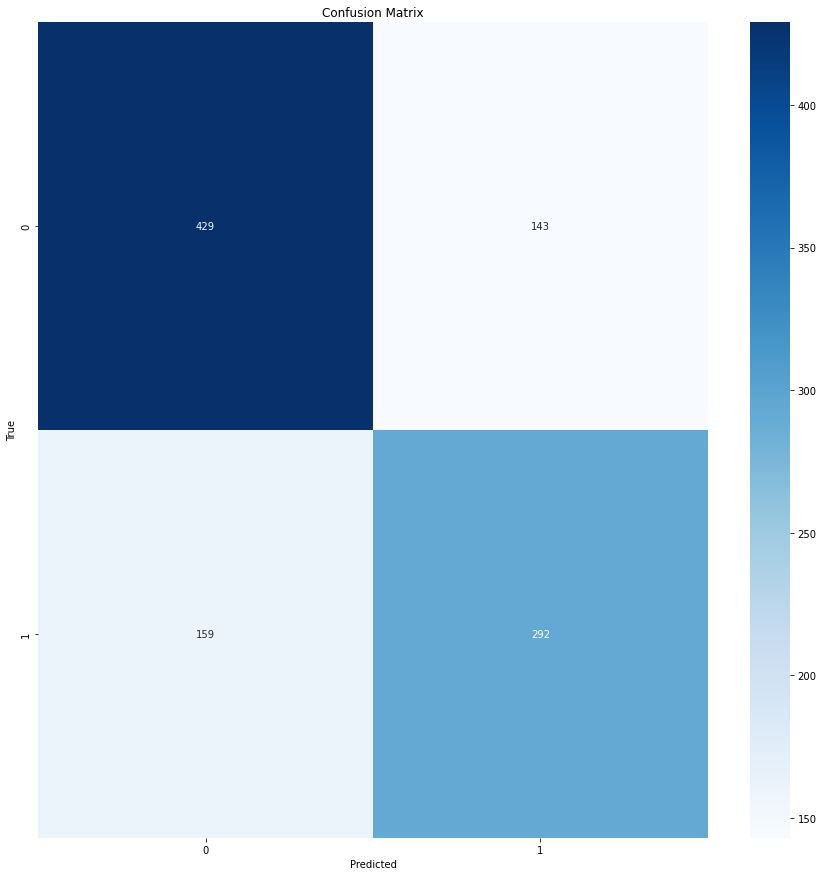

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.73      0.75      0.74       572
           1       0.67      0.65      0.66       451

    accuracy                           0.70      1023
   macro avg       0.70      0.70      0.70      1023
weighted avg       0.70      0.70      0.70      1023

##################################################  Saliency Maps  ##################################################

Class 0:


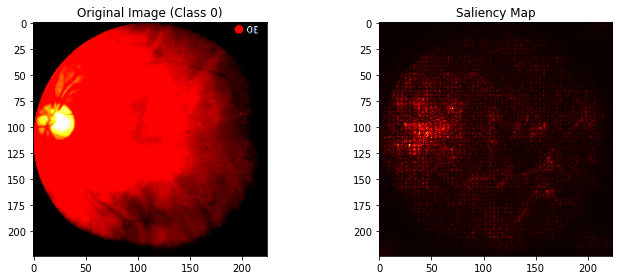

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


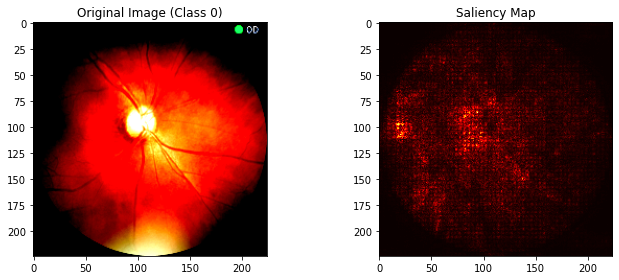

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


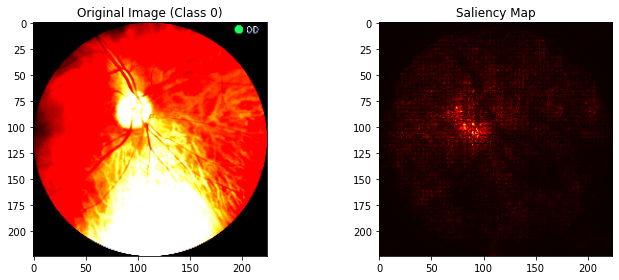

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


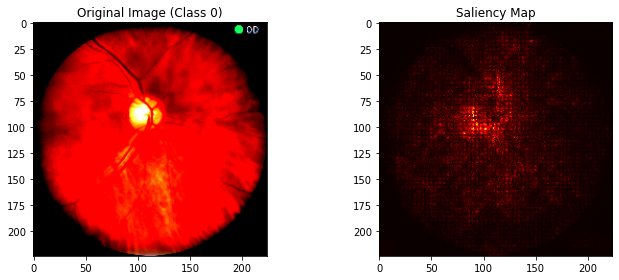

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


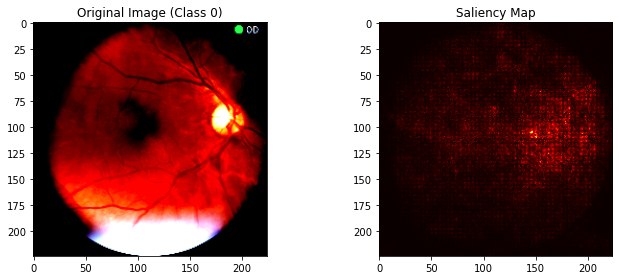

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


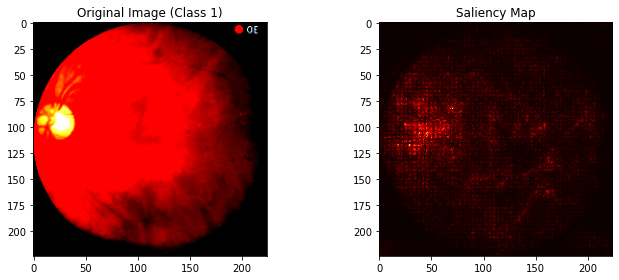

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


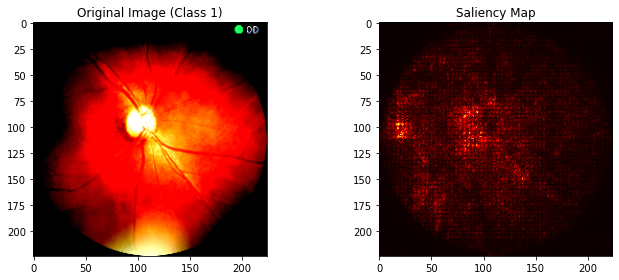

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


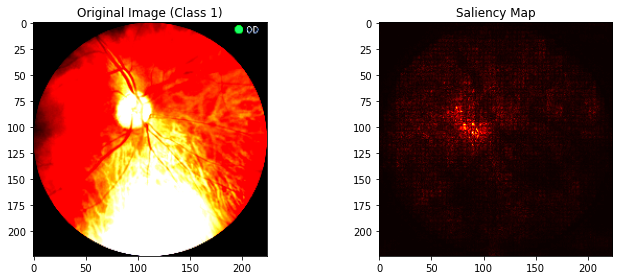

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


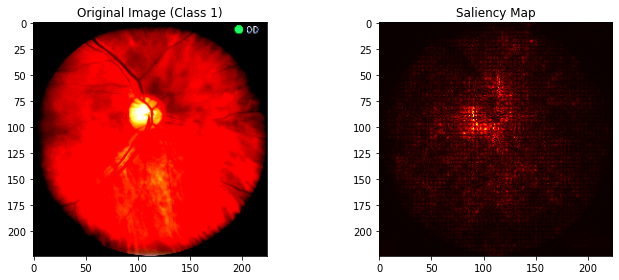

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


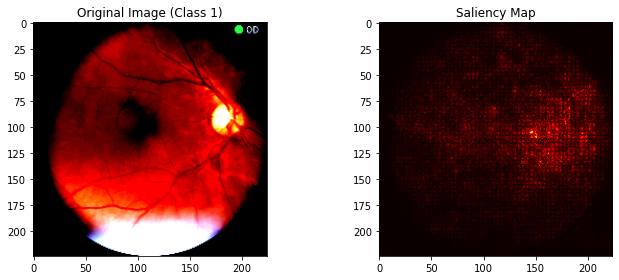

In [26]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 73/73 [00:14<00:00,  5.12it/s]


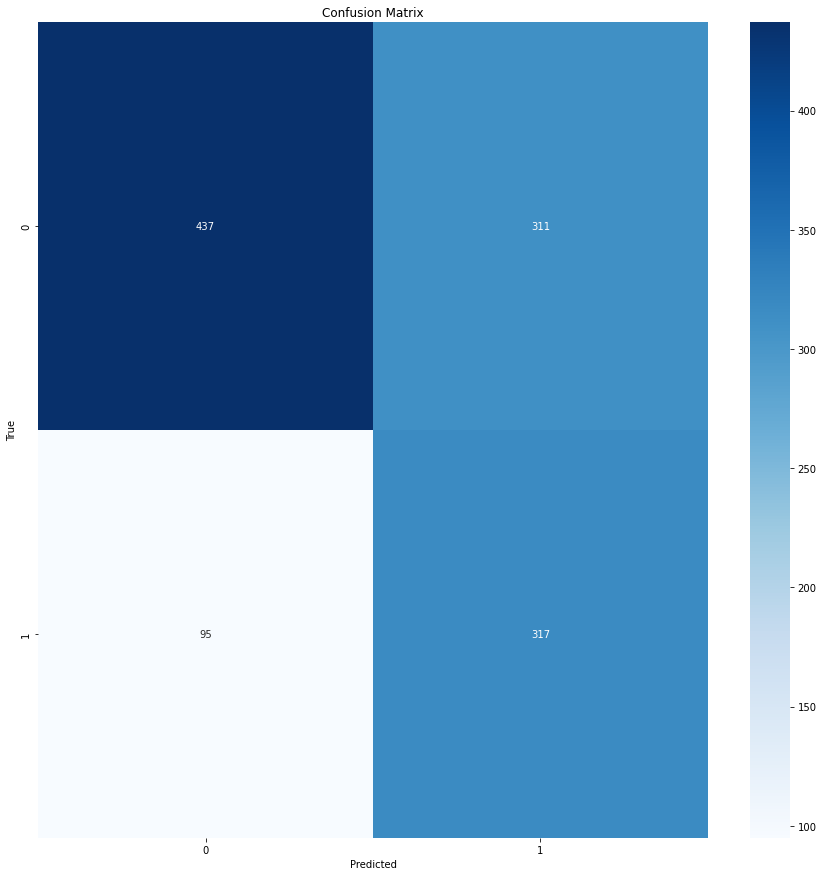

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       748
           1       0.50      0.77      0.61       412

    accuracy                           0.65      1160
   macro avg       0.66      0.68      0.65      1160
weighted avg       0.71      0.65      0.66      1160

##################################################  Saliency Maps  ##################################################

Class 0:


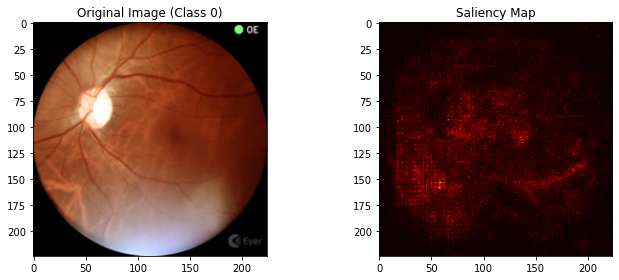

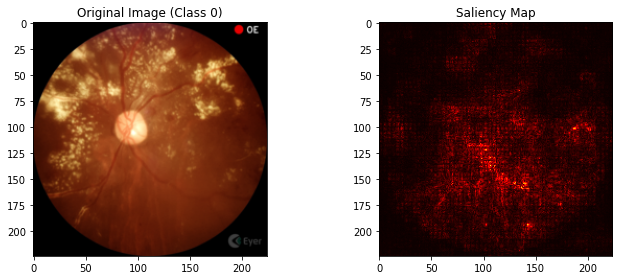

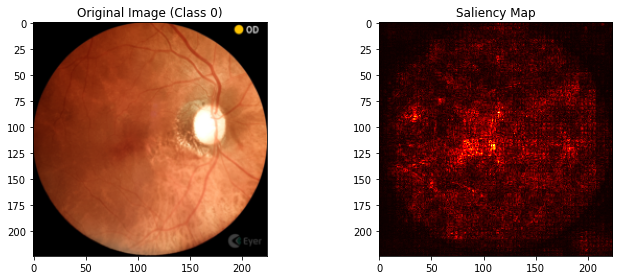

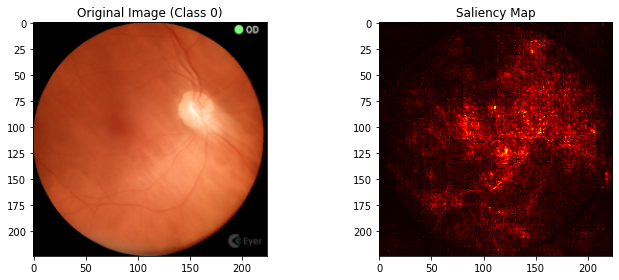

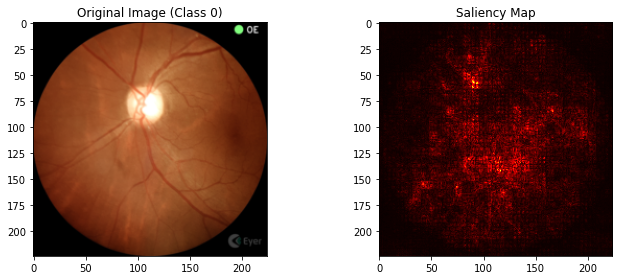

Class 1:


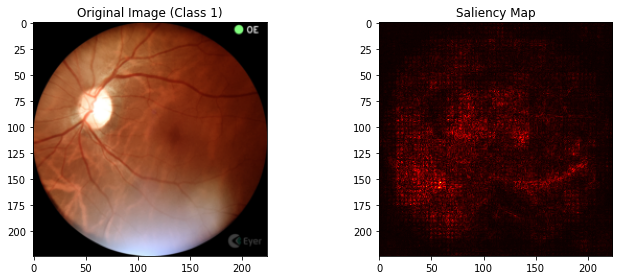

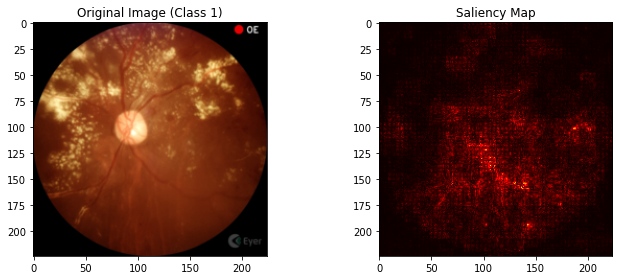

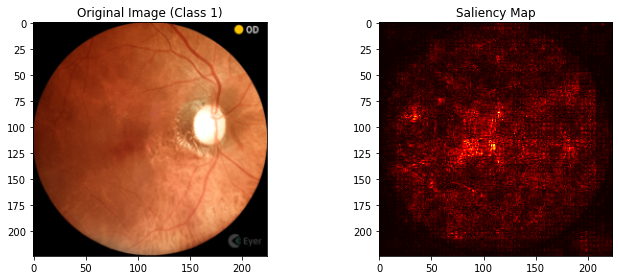

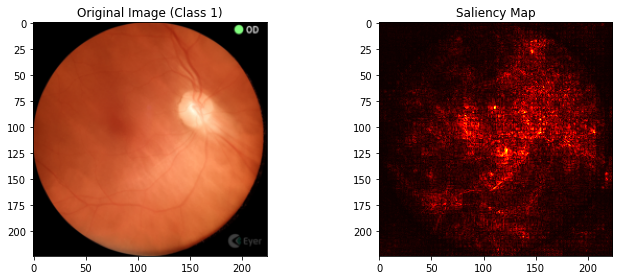

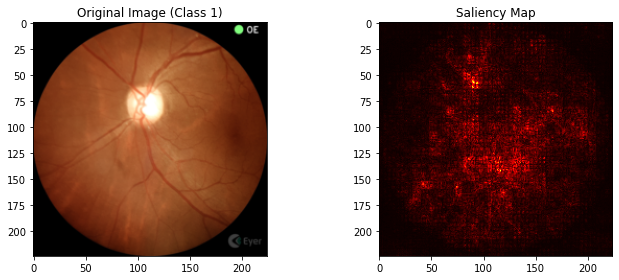

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


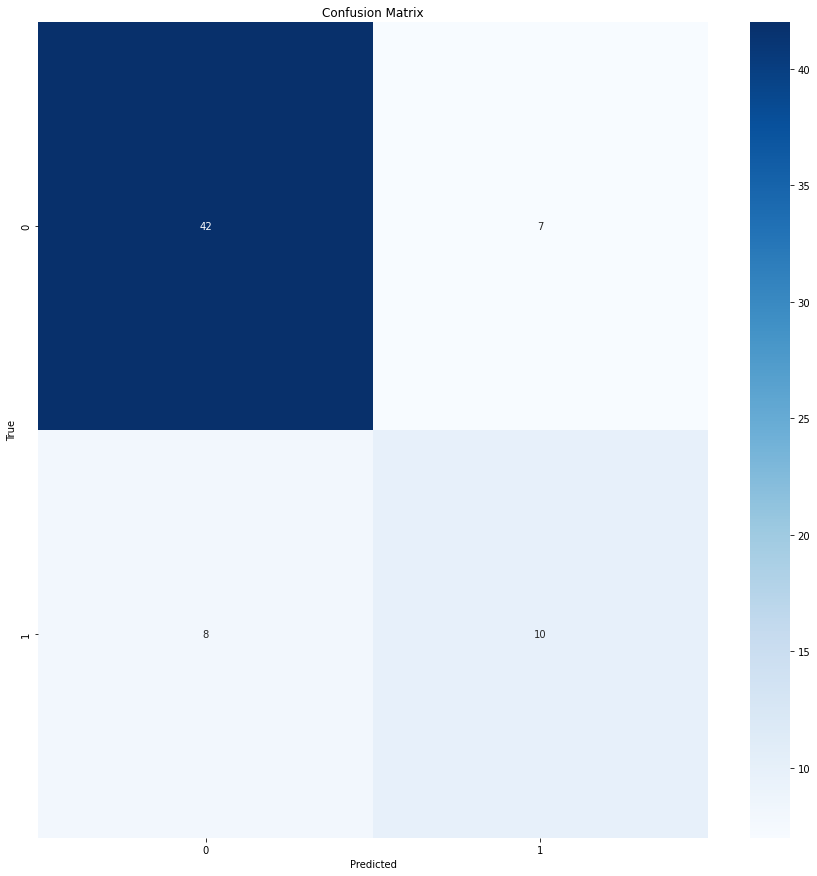

              precision    recall  f1-score   support

           0       0.84      0.86      0.85        49
           1       0.59      0.56      0.57        18

    accuracy                           0.78        67
   macro avg       0.71      0.71      0.71        67
weighted avg       0.77      0.78      0.77        67

##################################################  Saliency Maps  ##################################################

Class 0:


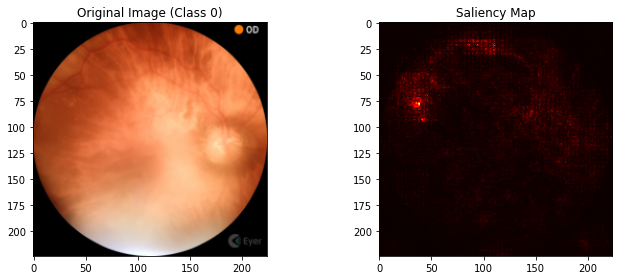

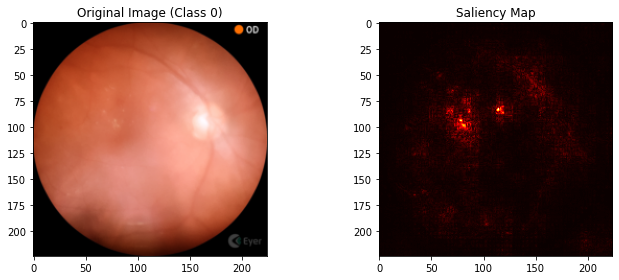

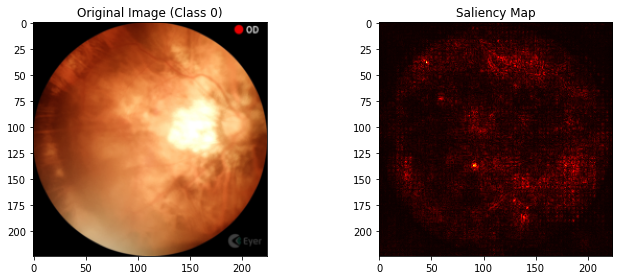

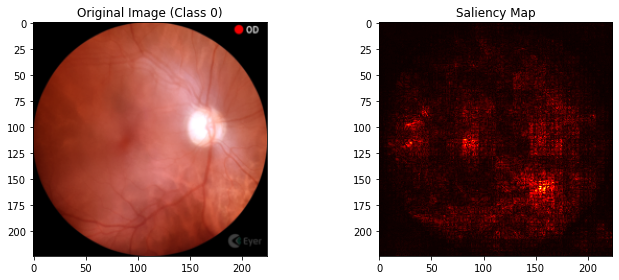

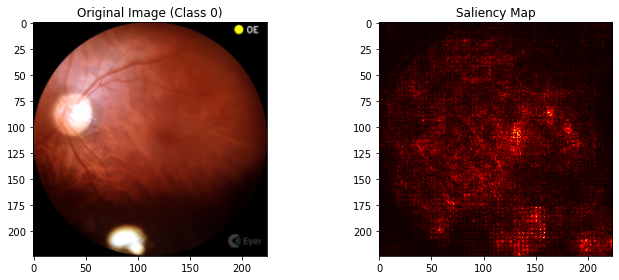

Class 1:


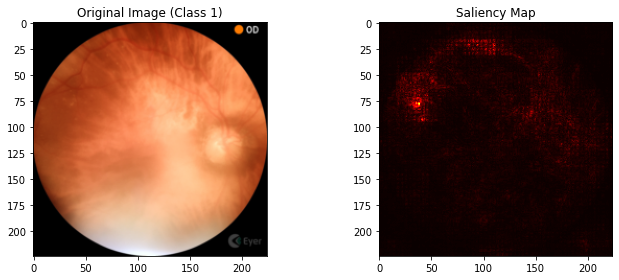

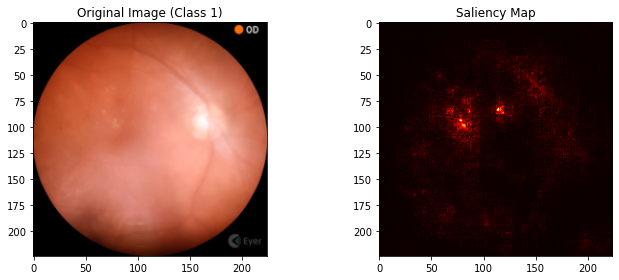

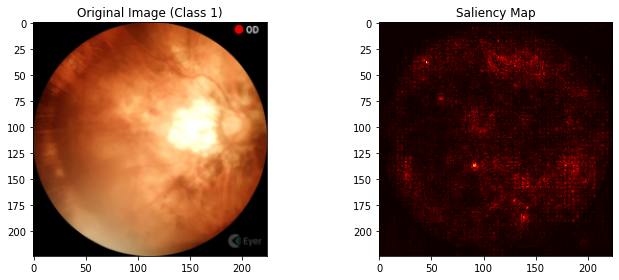

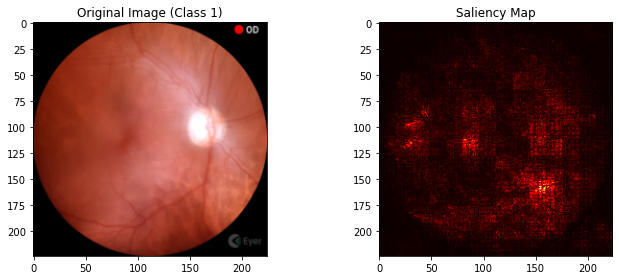

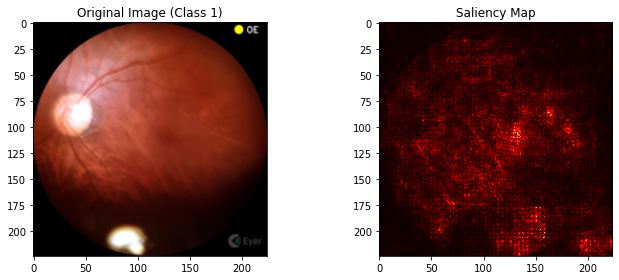

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)